## Importing Libraries

Importing required libraries

Using Plotting style from fivethirtyeight

In [1]:
# Importing libraries required for handling the data
import pandas as pd
import numpy as np
import random

# Importing libraries required for visualizing the data
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Importing libraries required for importing the data
from google.colab import files
import io

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

Uploading the Data file

In [2]:
uploaded = files.upload()

Saving housing.csv to housing (2).csv


Reading the data file into a pandas dataframe.

In [3]:
path = io.BytesIO(uploaded['housing.csv'])
df = pd.read_csv(path)

##Pre-Processing the dataset

Cleaning the data by dropping any na values, none of those exists in the dataset as nothing gets dropped.

Also shuffling the data.

Printing the head of the shufled dataset.

In [4]:
df.dropna(inplace=True)
df.sort_index(inplace=True)
print("Dataset Shape:",df.shape)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

Dataset Shape: (489, 4)


,RM,LSTAT,PTRATIO,MEDV
0,6.229,15.55,20.9,407400.0
1,6.606,7.37,16.6,489300.0
2,6.153,13.15,17.8,621600.0
3,6.770,4.84,17.9,558600.0
4,4.903,29.29,14.7,247800.0


Finding the ranges to bin these values in 3 groups.

In [5]:
print("min value:",df['MEDV'].min())
print("max value:",df['MEDV'].max()/3)
print("max value:",2*df['MEDV'].max()/3)
print("max value:",df['MEDV'].max())

min value: 105000.0
max value: 341600.0
max value: 683200.0
max value: 1024800.0


Labelling the MEDV based on the ranges and printing the head or the new data set

In [6]:
#Mapping MEDV Ranges to a numeric label
# Dividing into 3 bins
bins = [[105000.0,341600.0],[341601.0,683200.0],[683201.0,1024801.0]]
encoded_MEDV = []
i = 0
for v in df['MEDV']:
  for b in bins:
    if v in range(int(b[0]),int(b[1])):
      encoded_MEDV.append(bins.index(b)+1)
      i += 1
print(i)
df['encoded_MEDV'] = encoded_MEDV
df.head()

489


,RM,LSTAT,PTRATIO,MEDV,encoded_MEDV
0,6.229,15.55,20.9,407400.0,2
1,6.606,7.37,16.6,489300.0,2
2,6.153,13.15,17.8,621600.0,2
3,6.770,4.84,17.9,558600.0,2
4,4.903,29.29,14.7,247800.0,1


## Visualizing the dataset

Visualizing the dataset and the number of different species, used 2d data as its easy to visualize and work with

The following scatter plot shows the three clusters/groups of MEDV ranges we created.

Text(0.5, 0, 'LSTAT')

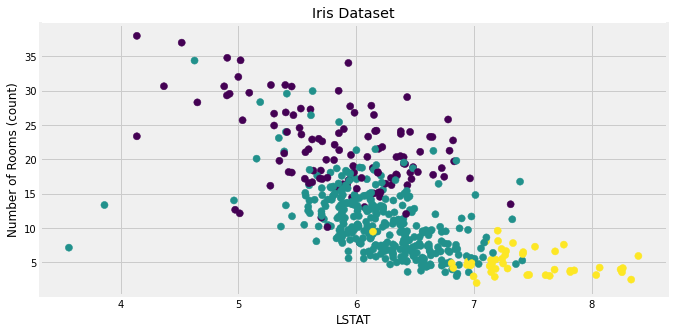

In [7]:
plt.figure(figsize=(10,5))
plt.title("Iris Dataset")
ax = plt.scatter(df['RM'], df['LSTAT'], 50, c=df['encoded_MEDV'])
plt.ylabel('Number of Rooms (count)')
plt.xlabel('LSTAT')

## Scaling the dataset

Scaling the required features as this helps the clustering algotrithms (KMeans and GMM) to perform better. 

Standard scaling the data, for every data point subtracting the mean and dividing by the standard deviation to make the distribution N(0,1)

In [8]:
df_mean = np.mean(df[['RM','LSTAT']])
df_std = np.std(df[['RM','LSTAT']])
df['Scaled_RM'] = df['RM'].map(lambda x: (x - df_mean['RM'])/df_std['RM'] )
df['Scaled_LSTAT'] = df['LSTAT'].map(lambda x: (x - df_mean['LSTAT'])/df_std['LSTAT'] )

As we formed 3 groups based on the MEDV ranges, choosing 3 random data points from the dataset, k1, k2, and k3

In [9]:
# Using information we can see from the scatter plots above, there are 3 likely clusters
k1, k2, k3 = random.randint(0,len(df)), random.randint(0,len(df)), random.randint(0,len(df))
print(k1,k2,k3)

401 267 413


## Machine Learning Algorithms

* KMeans
* GMM

### K Means

Using the 3 random choices for initial centroids for KMeans clustering, i.e. k1, k2, k3

Defining functions required for KMeans clustering

* centroid_centers(df): computes the new centroids, that is finds the mean of column belonging to each clusters
* kmeans_distance(df,centroids): computes the distance between each datapoint and all the clusters
* closest_cluster(distance): based on the euclidian distance to the cluster, the closest cluster is chosen for the label.

In [10]:
# centroids = [[df['SepalLengthCm'].loc[k1], df['SepalWidthCm'].loc[k1]],[df['SepalLengthCm'].loc[k2], df['SepalWidthCm'].loc[k2]],[df['SepalLengthCm'].loc[k3], df['SepalWidthCm'].loc[k3]]]
maxIter = 100
X_KMeans = df[['Scaled_RM','Scaled_LSTAT']]
X_KMeans['label'] = [ random.randint(0,3) for _ in range(len(X_KMeans))]
centroids = X_KMeans.loc[[k1,k2,k3]]
centroids = centroids[centroids.columns[:-1]].values
n_clusters = 3

def centroids_centers(df):
  centroids = np.zeros((n_clusters,df.shape[1]-1))
  for k in range(n_clusters):
    centroids[k] = np.mean(df[df['label']==k+1][df.columns[:-1]],axis=0)
  return centroids

def kmeans_distance(df,centroids):
  dist = np.zeros((df.shape[0], n_clusters))
  for k in range(n_clusters):
    rn = df - centroids[k,:]
    rn['Scaled_RM'] = rn['Scaled_RM']**2
    rn['Scaled_LSTAT'] = rn['Scaled_LSTAT']**2
    dist[:, k] = (rn.sum(axis=1))**0.5
  return dist

def closest_cluster(distance):
  return (np.argmin(distance, axis=1) + 1)

Following is the fit function, in this since KMeans is an iterative process, for every iteration we compute the distance between every datapoint and the centroid, then assign the new labels based on the distance. Based on the new labels new centroids are chosen for the clusters. These steps are repeated untill the new centroids are the same as the previous iteration centroids, i.e. no change and hence converged. 

In [11]:
for i in range(maxIter):
  print("Iteration:",i+1)
  old_centroids = centroids
  dist = kmeans_distance(X_KMeans[X_KMeans.columns[:-1]],old_centroids)
  new_labels = closest_cluster(dist)
  X_KMeans['label'] = new_labels
  centroids = centroids_centers(X_KMeans)
  if np.all(centroids == old_centroids):
    break
print("Centroids:\n",centroids)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Centroids:
 [[ 0.98991294 -0.92445128]
 [-0.31198175  0.10595091]
 [-1.18298291  1.87242523]]


A scatter plot showing the clusters formed by KMeans

Text(0.5, 0, 'LSTAT')

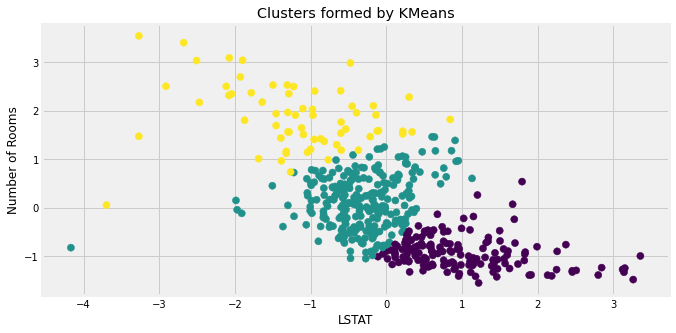

In [12]:
plt.figure(figsize=(10,5))
plt.title("Clusters formed by KMeans")
plt.scatter(X_KMeans['Scaled_RM'], X_KMeans['Scaled_LSTAT'], 50, c=X_KMeans['label'])
plt.ylabel('Number of Rooms')
plt.xlabel('LSTAT')

### Gaussian Mixture Model

Initializing initial parameters the expectaion maximization algorithm will start with, using the 3 random choices from the data set and chosing random sigma and fraction per class.

In [13]:
init_params = {
    "mu": list(df.loc[[k1,k2,k3]][['Scaled_RM','Scaled_LSTAT']].values),
    "sig": [[1,1],[1,1],[1,1]],
    "fpc": [0.33,0.33,0.34]
}
params_df = pd.DataFrame.from_dict(init_params, orient = 'index')
params_df = params_df.transpose()
params_df

,mu,sig,fpc
0,"[2.45681654314979, -1.3243773714545175]","[1, 1]",0.33
1,"[-0.32704695137168116, 0.8283504601788917]","[1, 1]",0.33
2,"[0.21728389951240473, 1.5195414711235649]","[1, 1]",0.34


Defining functions required for expectation maximization

* prob(val,params): Calculates the probability based on the parameters for a datapoint belonging to each of the clusters
* expectation(df,params): Uses the probability function to compute the probabilty per class, and using that assign new labels.
* maximization(df,params): Using the new labels from the expectaion step, finds new probability and cluster parameters such as mean(mu), standard deviation (sig), and fraction per class.
* em_distance(old,new): computes the mean squared error between the old parameters and the new parameters (mu,sigma,fpc)

In [14]:
# Calculating the probability for the elements based on the parameters
def prob(val, params):
  p = params[2]
  for i in range(0,len(val)):
    p *= norm.pdf(val[i], params[0][i], params[1][i])
  return p

# assigning labels to data points based on the probability
def expectation(df, params):
  new_labels = []
  for r in df.iterrows():
    x, y = r[1]['Scaled_RM'],r[1]['Scaled_LSTAT']
    # probability for this datapoint belonging to any of the three clusters
    p_c1 = prob([x,y],params.loc[0])
    p_c2 = prob([x,y],params.loc[1])
    p_c3 = prob([x,y],params.loc[2])

    p_c = [p_c1,p_c2,p_c3]

    # Asssigning labels according to the probabilities calculated
    new_labels.append((p_c.index(max(p_c))+1))

  df['label'] = new_labels
  return df
  
def maximization(df,params):
  cluster1 = df[df['label']==1]
  cluster2 = df[df['label']==2]
  cluster3 = df[df['label']==3]

  p_c1 = float(len(cluster1)/len(df))
  p_c2 = float(len(cluster2)/len(df))
  p_c3 = 1-p_c1-p_c2
  params['fpc'] = [p_c1,p_c2,p_c3]

  mu_c1 = [cluster1['Scaled_RM'].mean(),cluster1['Scaled_LSTAT'].mean()]
  mu_c2 = [cluster2['Scaled_RM'].mean(),cluster2['Scaled_LSTAT'].mean()]
  mu_c3 = [cluster3['Scaled_RM'].mean(),cluster3['Scaled_LSTAT'].mean()]
  params['mu'] = [mu_c1,mu_c2,mu_c3]

  sig_c1 = [cluster1['Scaled_RM'].std(),cluster1['Scaled_LSTAT'].std()]
  sig_c2 = [cluster2['Scaled_RM'].std(),cluster2['Scaled_LSTAT'].std()]
  sig_c3 = [cluster3['Scaled_RM'].std(),cluster3['Scaled_LSTAT'].std()]
  params['sig'] = [sig_c1,sig_c2,sig_c3]

  return params

def em_distance(old,new):
  dist = 0
  for r in range(0,len(old)):
    for i in range(len(new['mu'][r])):
      dist += (new['mu'][r][i] - old['mu'][r][i])**2
  return dist**0.5

Following is the fit function, follows the Expectaion-maximization algorithm with the helper functions defined above.

The algorithm converges when the meanShift, the euclidian distance between the old mean (old cluster center) and the new mean (new cluster center) is less than 0.01

In [15]:
params_df = pd.DataFrame.from_dict(init_params, orient = 'index')
params_df = params_df.transpose()
params_df

meanShift = 999999
iters = 0
X_GMM = df[['Scaled_RM','Scaled_LSTAT']]
X_GMM['label'] = [ random.randint(0,3) for _ in range(len(X_GMM))]

while meanShift > 0.01:
    iters += 1
    
    #Expectation-step
    new_df = expectation(X_GMM.copy(), params_df)
    
    #Maximization-step
    new_params = maximization(new_df, params_df.copy())
    
    #Updating the shift distance
    meanShift = em_distance(params_df, new_params)
    
    #updating the new labels and parameters for the next iteration
    X_GMM = new_df
    params_df = new_params
    print("Iteration:",iters,"Mean Squared error:",meanShift)
params_df

Iteration: 1 Mean Squared error: 1.4226899660548966
Iteration: 2 Mean Squared error: 1.244912962546054
Iteration: 3 Mean Squared error: 0.29258857943424127
Iteration: 4 Mean Squared error: 0.14241112998903518
Iteration: 5 Mean Squared error: 0.02920767465250251
Iteration: 6 Mean Squared error: 0.008583844281113957


,mu,sig,fpc
0,"[1.1348831512610764, -1.060304241352803]","[0.7668611549746391, 0.21309872821278467]",0.245399
1,"[-0.2105334336579036, 0.1154543154267171]","[0.568502256299604, 0.6380583310131115]",0.666667
2,"[-1.5709785762525048, 2.083683770540147]","[0.9618046803755989, 0.7766374955410241]",0.087935


A scatter plot showing the clusters formed by the Gaussian Mixture Model

Text(0.5, 0, 'LSTAT')

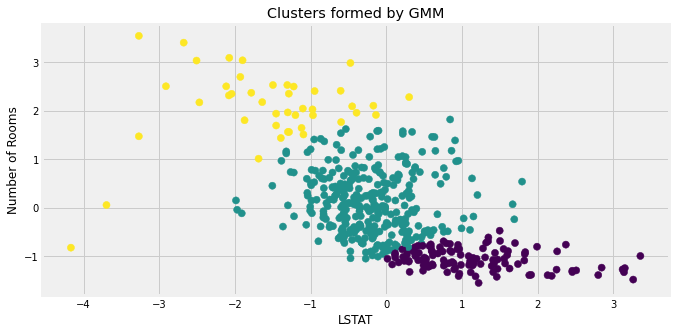

In [16]:
plt.figure(figsize=(10,5))
plt.title("Clusters formed by GMM")
plt.scatter(X_GMM['Scaled_RM'], X_GMM['Scaled_LSTAT'], 50, c=X_GMM['label'])
plt.ylabel('Number of Rooms')
plt.xlabel('LSTAT')

##Conclusion:

The Boston Housing dataset is another good dataset as its again a complete dataset. For GMM I again started with a fraction per class equally distributed, i.e. [0.33,0.33,0.34] this time random. 

In the following output we can see all 3 clusters, starting from the Original (true) clusters, then KMeans clusters, and finally GMM Clusters. Both the models again miss out the outliers and are very dependent on the initial random choices. That means with every run we have a different result as the random choices are different.

Overall both KMeans and GMM performed similarly, neither of them are close to the original grouping of the data.

This data seems a bit more noisy than the Iris data set and hence we cans ee why both the models do not perform as well as they perform on the Iris dataset.

Text(0, 0.5, 'LSTAT')

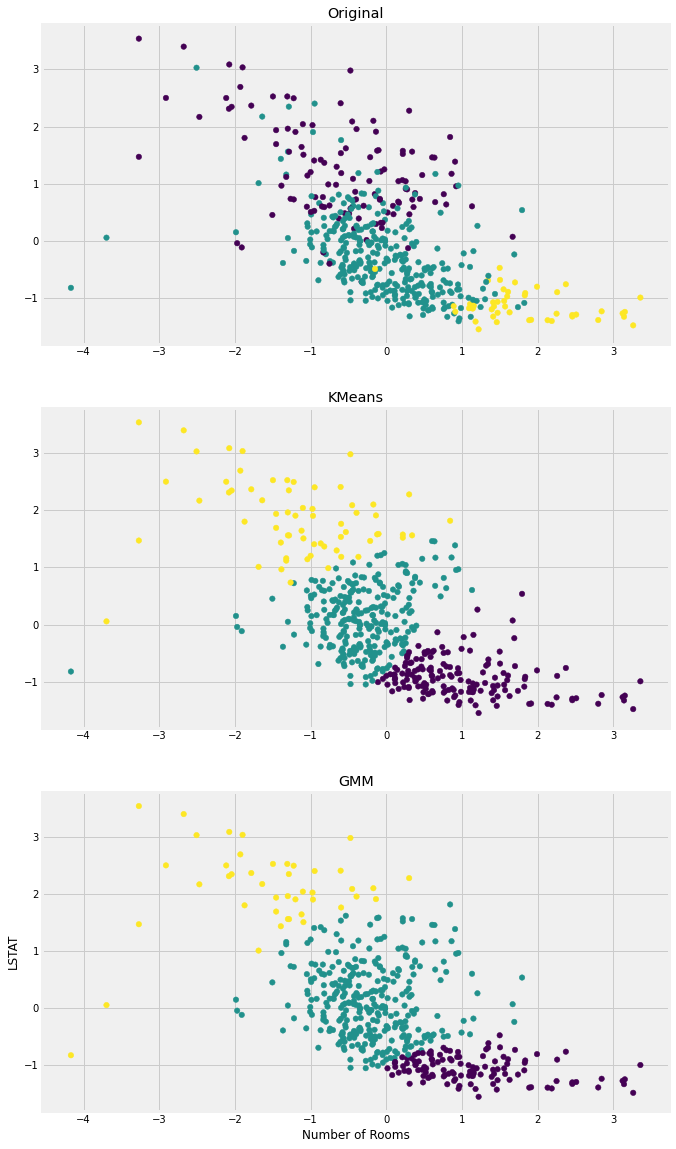

In [17]:
fig, axs = plt.subplots(3, figsize=(10,20))
axs[0].scatter(df['Scaled_RM'], df['Scaled_LSTAT'], 30, c=df['encoded_MEDV'])
axs[0].set_title('Original')

axs[1].scatter(X_KMeans['Scaled_RM'], X_KMeans['Scaled_LSTAT'], 30, c=X_KMeans['label'])
axs[1].set_title('KMeans')

axs[2].scatter(X_GMM['Scaled_RM'], X_GMM['Scaled_LSTAT'], 30, c=X_GMM['label'])
axs[2].set_title('GMM')
axs[2].set_xlabel('Number of Rooms')
axs[2].set_ylabel('LSTAT')